In [32]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot


In [33]:
# by MLdP on 02/22/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis
import numpy as np
from pykalman import KalmanFilter
#-------------------------------------------------------------------------------
def fitKCA(t,z,q,fwd=0):
    '''
    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance
    fwd: number of steps to forecast (optional, default=0)
    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
            [0,1,h],
            [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf=kf.em(z)
    #4) Smooth
    x_mean,x_covar=kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1],filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [34]:
# by MLdP on 02/20/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis of a periodic function
import matplotlib.pyplot as pp
mainPath=''
#---------------------------------------------------------
def vsFFT(t,z):
    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=.001)[:2]
    #4) Plot KCA's point estimates
    color=['b','g','r']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', color=color[0])
    pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', color=color[1])
    pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', color=color[2])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    pp.clf();pp.close() # reset pylab
    return

In [35]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [36]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=900)
#no option to pass in 3600 sec candles
df = df[df.index % 4 == 0]
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']

In [37]:
def run(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    
    df['velocity'] = result[0][:,1]
    df['acceleration'] = result[0][:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)
    
    prophet_df = df[['ds', 'velocity', 'acceleration']].copy()

    prophet_df['y'] = prophet_df['velocity']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

    prophet_df['y'] = prophet_df['acceleration']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)


/Users/robert/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


count    14972.000000
mean         0.000118
std          0.026069
min         -0.431019
25%         -0.004335
50%          0.000318
75%          0.005200
max          0.269612
Name: velocity, dtype: float64
count    1.497200e+04
mean    -4.076066e-09
std      2.752183e-06
min     -3.670910e-05
25%     -5.794496e-07
50%     -8.775322e-09
75%      5.483913e-07
max      3.301620e-05
Name: acceleration, dtype: float64


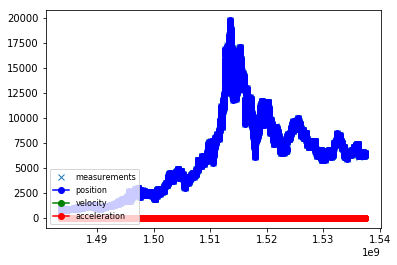

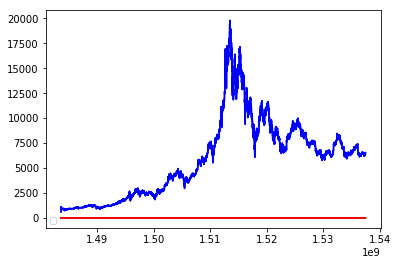

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/robert/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


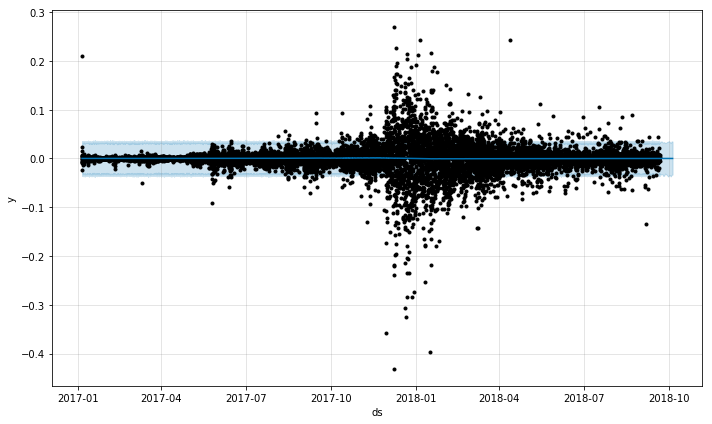

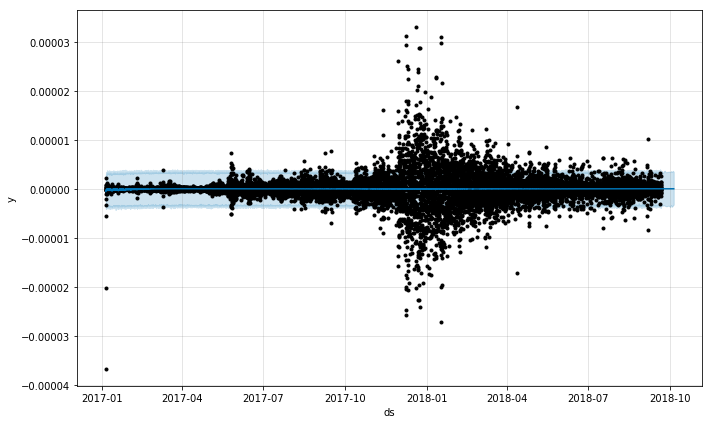

In [38]:
run(df)

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  
/Users/robert/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


(2017, 1)
count    641.000000
mean       0.000349
std        0.008913
min       -0.018641
25%       -0.000450
50%        0.000079
75%        0.000563
max        0.216237
Name: velocity, dtype: float64
count    6.410000e+02
mean    -9.724784e-08
std      1.734866e-06
min     -3.739582e-05
25%     -9.136957e-08
50%     -2.063526e-09
75%      8.060084e-08
max      2.121343e-06
Name: acceleration, dtype: float64


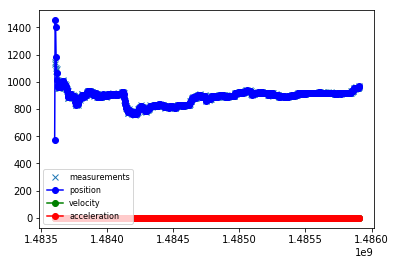

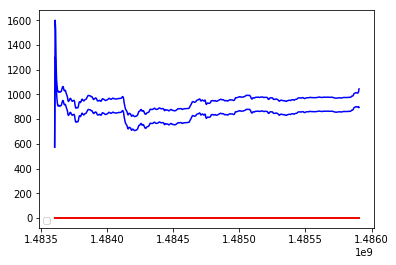

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/robert/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 2)


/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


count    672.000000
mean       0.000433
std        0.007673
min       -0.016966
25%       -0.000389
50%        0.000165
75%        0.000643
max        0.189712
Name: velocity, dtype: float64
count    6.720000e+02
mean    -8.274036e-08
std      1.466566e-06
min     -3.198177e-05
25%     -8.825035e-08
50%     -4.481832e-09
75%      8.711133e-08
max      2.352337e-06
Name: acceleration, dtype: float64


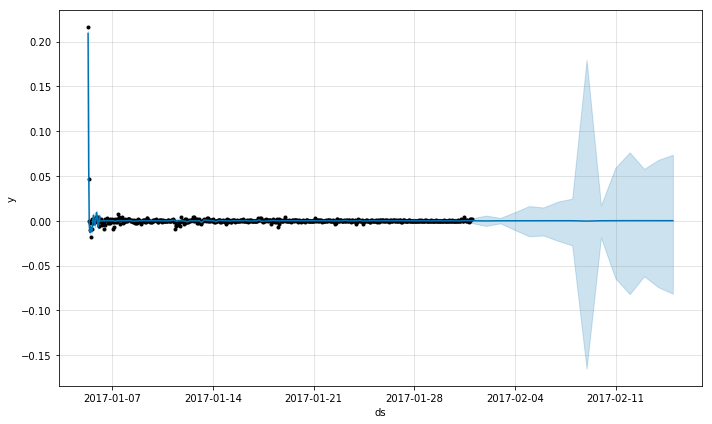

ValueError: view limit minimum -73643078.971875 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

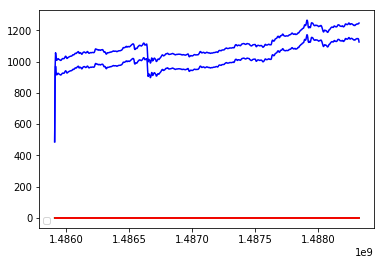

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 3)
count    744.000000
mean       0.000340
std        0.009103
min       -0.032808
25%       -0.000868
50%        0.000100
75%        0.000994
max        0.232169
Name: velocity, dtype: float64
count    7.440000e+02
mean    -9.089158e-08
std      1.731841e-06
min     -3.931525e-05
25%     -1.673133e-07
50%     -1.086312e-08
75%      1.351794e-07
max      3.868096e-06
Name: acceleration, dtype: float64


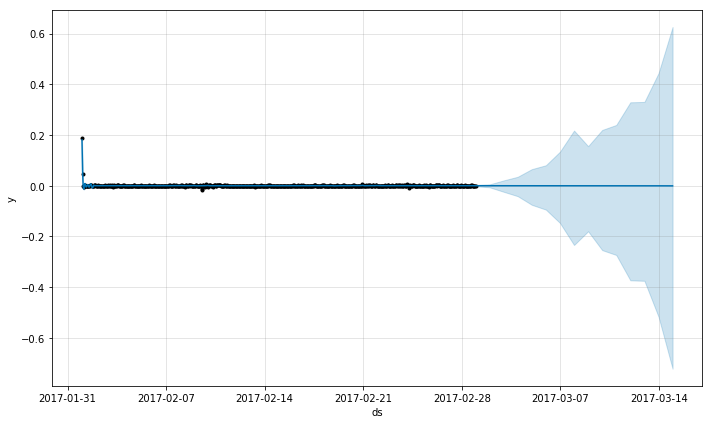

ValueError: view limit minimum -73776970.92812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

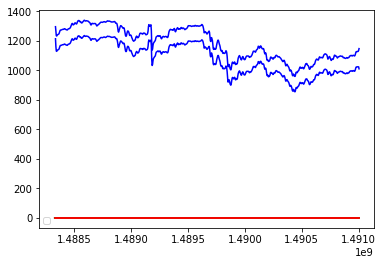

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 4)
count    720.000000
mean       0.000494
std        0.007982
min       -0.005692
25%       -0.000481
50%        0.000119
75%        0.000763
max        0.205203
Name: velocity, dtype: float64
count    7.200000e+02
mean    -8.294541e-08
std      1.491408e-06
min     -3.343235e-05
25%     -1.034512e-07
50%     -5.028204e-09
75%      1.030015e-07
max      6.164635e-07
Name: acceleration, dtype: float64


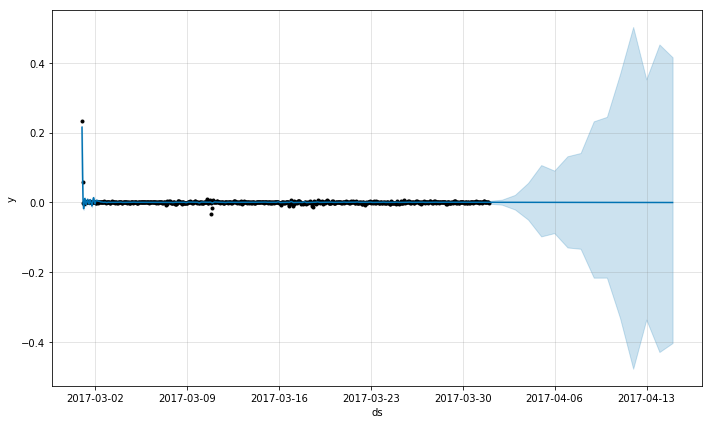

ValueError: view limit minimum -73906541.52812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

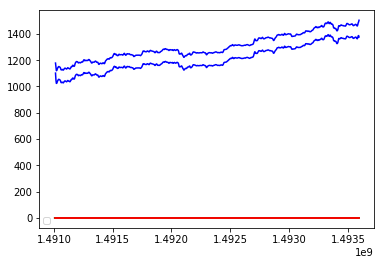

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 5)
count    744.000000
mean       0.000738
std        0.012223
min       -0.064656
25%       -0.001457
50%        0.000563
75%        0.003037
max        0.275098
Name: velocity, dtype: float64
count    7.440000e+02
mean    -1.084693e-07
std      2.190875e-06
min     -4.536316e-05
25%     -3.598633e-07
50%     -1.356006e-08
75%      3.221731e-07
max      8.004848e-06
Name: acceleration, dtype: float64


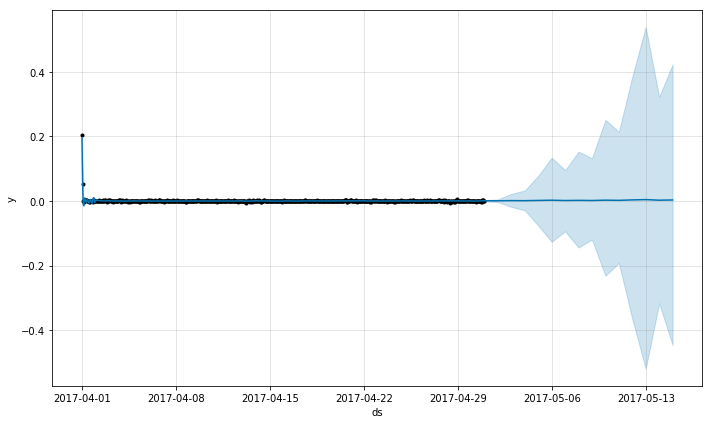

ValueError: view limit minimum -74040428.978125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

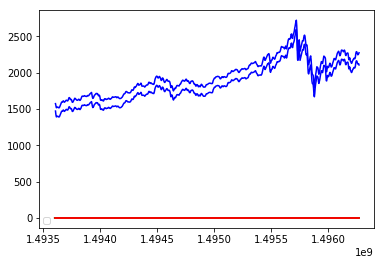

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 6)
count    720.000000
mean       0.000792
std        0.016867
min       -0.033617
25%       -0.002290
50%        0.000550
75%        0.003201
max        0.406719
Name: velocity, dtype: float64
count    7.200000e+02
mean    -1.689963e-07
std      2.945064e-06
min     -6.272878e-05
25%     -4.290323e-07
50%     -5.992226e-08
75%      3.686423e-07
max      3.887654e-06
Name: acceleration, dtype: float64


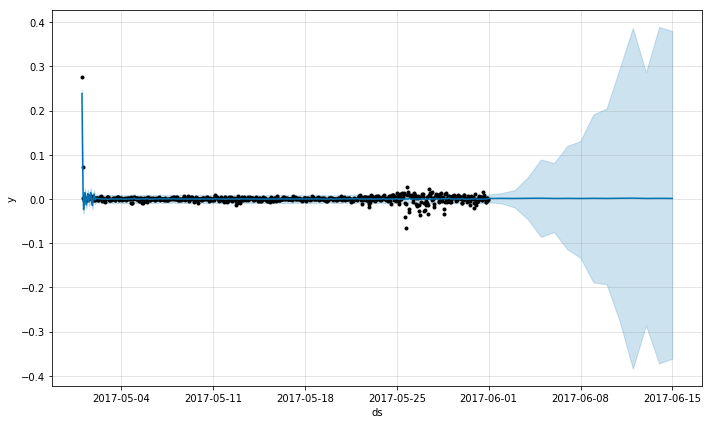

ValueError: view limit minimum -74169997.478125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

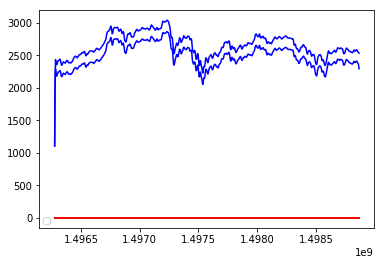

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 7)
count    744.000000
mean       0.000917
std        0.017307
min       -0.015595
25%       -0.002732
50%        0.000094
75%        0.002928
max        0.436261
Name: velocity, dtype: float64
count    7.440000e+02
mean    -1.717798e-07
std      3.151644e-06
min     -7.025379e-05
25%     -4.161796e-07
50%     -2.527454e-08
75%      3.577047e-07
max      3.051293e-06
Name: acceleration, dtype: float64


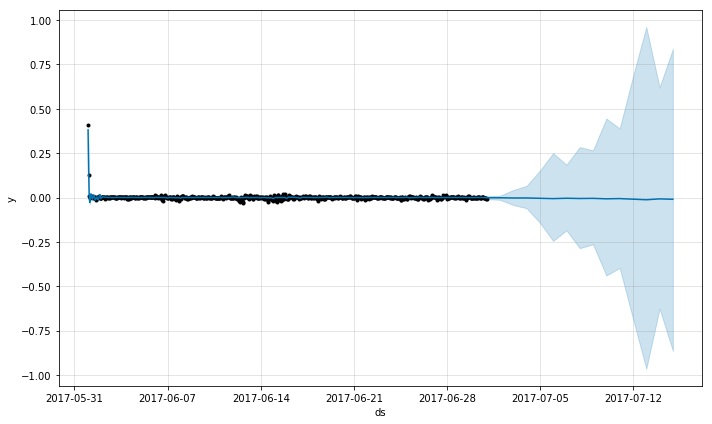

ValueError: view limit minimum -74303884.92812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

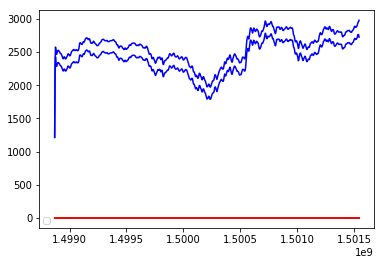

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 8)
count    744.000000
mean       0.001599
std        0.021097
min       -0.029173
25%       -0.002553
50%        0.000626
75%        0.003864
max        0.521563
Name: velocity, dtype: float64
count    7.440000e+02
mean    -2.042715e-07
std      3.757368e-06
min     -8.226676e-05
25%     -5.249605e-07
50%     -6.535313e-09
75%      4.855212e-07
max      4.737259e-06
Name: acceleration, dtype: float64


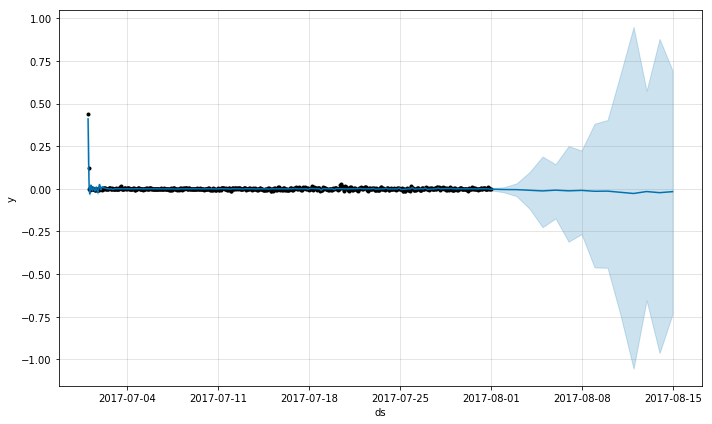

ValueError: view limit minimum -74437773.42812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

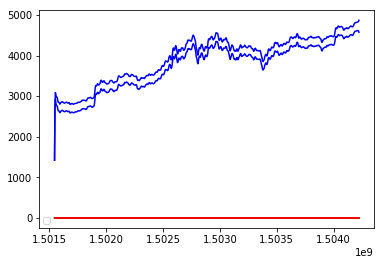

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 9)
count    720.000000
mean       0.001386
std        0.034251
min       -0.050215
25%       -0.004451
50%        0.000409
75%        0.004456
max        0.844293
Name: velocity, dtype: float64
count    7.200000e+02
mean    -3.418688e-07
std      6.065570e-06
min     -1.305386e-04
25%     -6.993514e-07
50%     -4.011007e-08
75%      6.858432e-07
max      5.816169e-06
Name: acceleration, dtype: float64


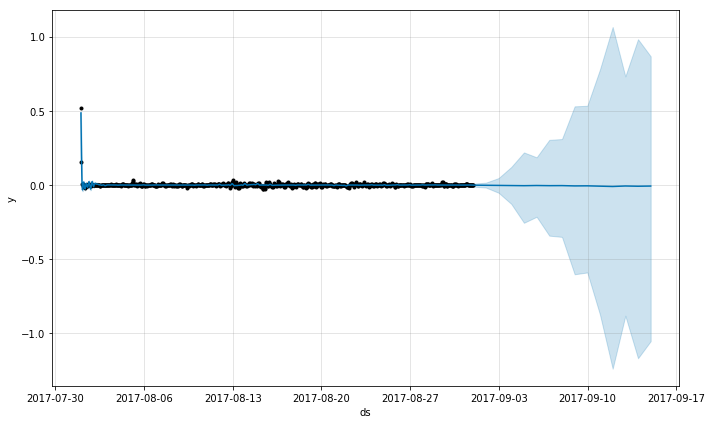

ValueError: view limit minimum -74567340.87812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

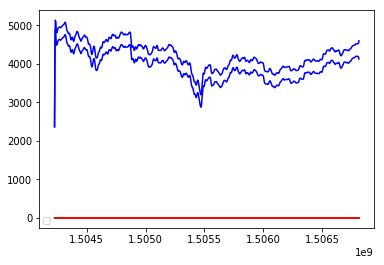

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 10)
count    744.000000
mean       0.002136
std        0.030603
min       -0.031452
25%       -0.003044
50%        0.000886
75%        0.004396
max        0.769636
Name: velocity, dtype: float64
count    7.440000e+02
mean    -2.956298e-07
std      5.478185e-06
min     -1.205421e-04
25%     -6.046781e-07
50%      1.617326e-08
75%      6.159452e-07
max      3.737832e-06
Name: acceleration, dtype: float64


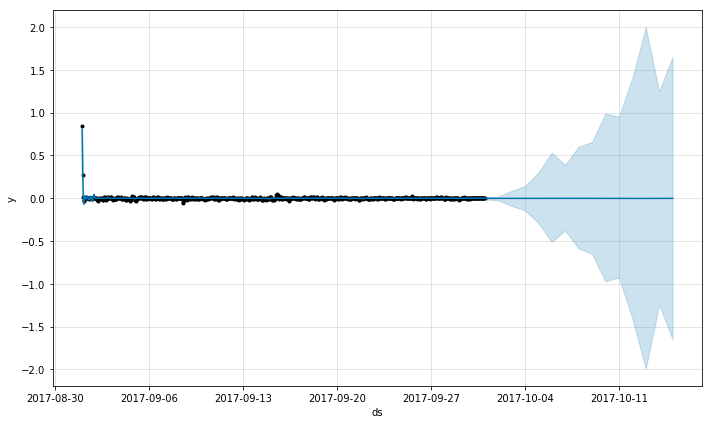

ValueError: view limit minimum -74701228.32812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

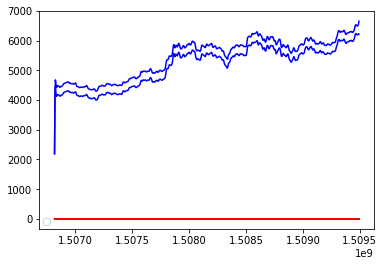

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 11)
count    720.000000
mean       0.003510
std        0.047334
min       -0.165997
25%       -0.005588
50%        0.002507
75%        0.010014
max        1.121257
Name: velocity, dtype: float64
count    7.200000e+02
mean    -4.102597e-07
std      8.257273e-06
min     -1.734039e-04
25%     -1.152713e-06
50%     -9.394366e-08
75%      1.089656e-06
max      1.940254e-05
Name: acceleration, dtype: float64


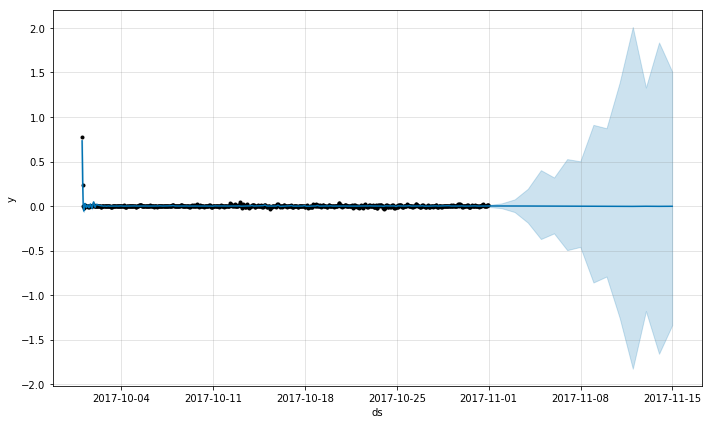

ValueError: view limit minimum -74830796.82812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

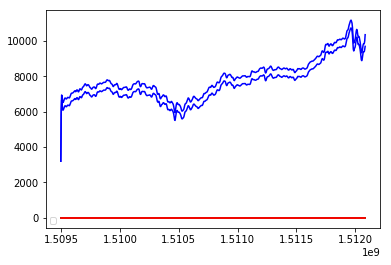

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2017, 12)
count    744.000000
mean       0.004457
std        0.079452
min       -0.178303
25%       -0.022428
50%        0.004647
75%        0.029750
max        1.635284
Name: velocity, dtype: float64
count    7.440000e+02
mean    -6.377424e-07
std      1.374580e-05
min     -2.625119e-04
25%     -4.255226e-06
50%      5.932075e-08
75%      4.317318e-06
max      3.087759e-05
Name: acceleration, dtype: float64


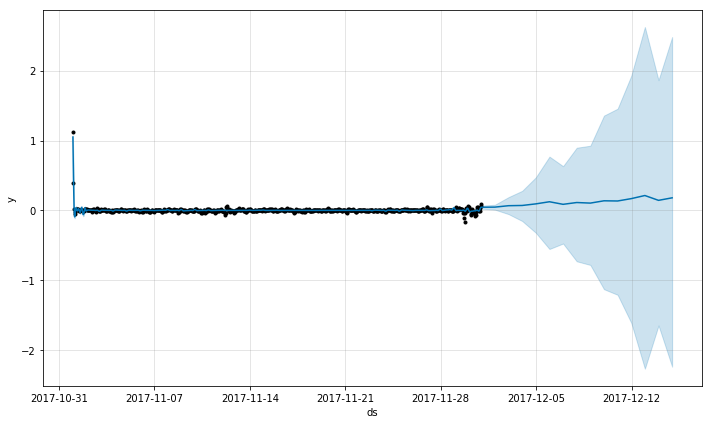

ValueError: view limit minimum -74964684.27812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

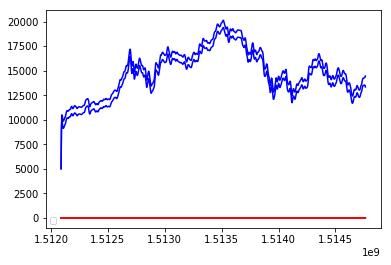

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 1)
count    744.000000
mean       0.002832
std        0.094154
min       -0.172681
25%       -0.018822
50%       -0.000622
75%        0.018903
max        2.237902
Name: velocity, dtype: float64
count    7.440000e+02
mean    -8.623866e-07
std      1.652481e-05
min     -3.510942e-04
25%     -3.116765e-06
50%     -8.874204e-08
75%      3.233783e-06
max      2.241703e-05
Name: acceleration, dtype: float64


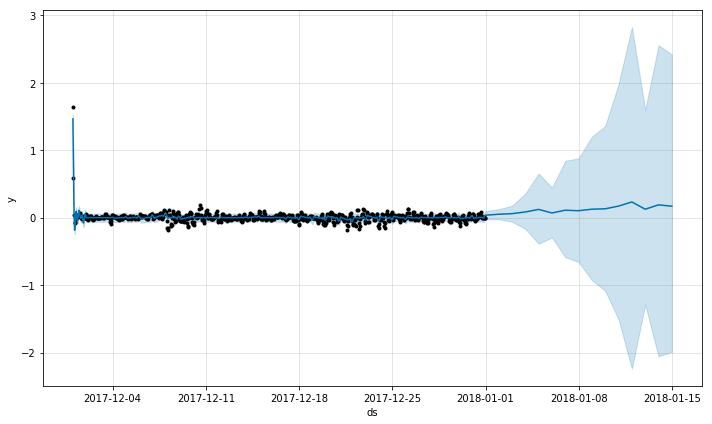

ValueError: view limit minimum -75098572.77812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

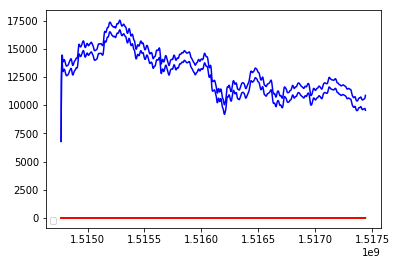

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 2)
count    672.000000
mean       0.003401
std        0.074420
min       -0.082923
25%       -0.015708
50%        0.001112
75%        0.015418
max        1.723747
Name: velocity, dtype: float64
count    6.720000e+02
mean    -7.816037e-07
std      1.311482e-05
min     -2.696266e-04
25%     -2.151478e-06
50%     -6.705829e-08
75%      2.124756e-06
max      1.279636e-05
Name: acceleration, dtype: float64


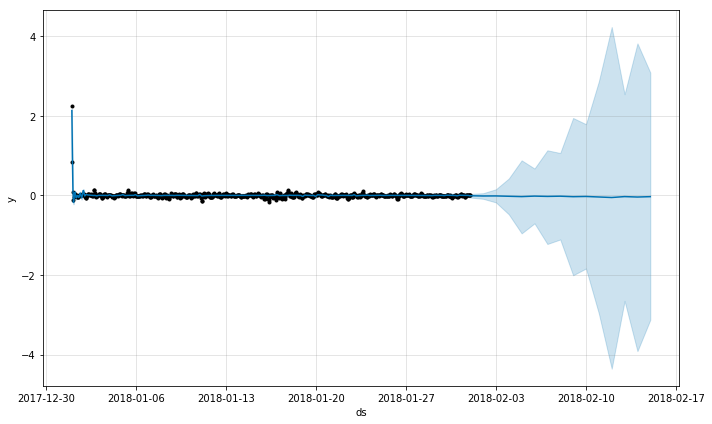

ValueError: view limit minimum -75219500.228125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

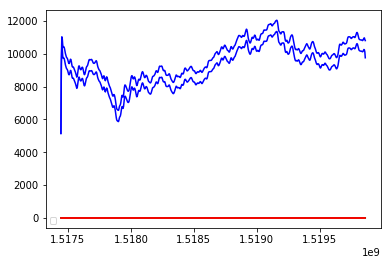

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 3)
count    744.000000
mean       0.001872
std        0.070526
min       -0.100309
25%       -0.010559
50%       -0.000422
75%        0.009100
max        1.744363
Name: velocity, dtype: float64
count    7.440000e+02
mean    -6.794587e-07
std      1.233719e-05
min     -2.688234e-04
25%     -1.590037e-06
50%     -5.529335e-08
75%      1.622971e-06
max      1.130530e-05
Name: acceleration, dtype: float64


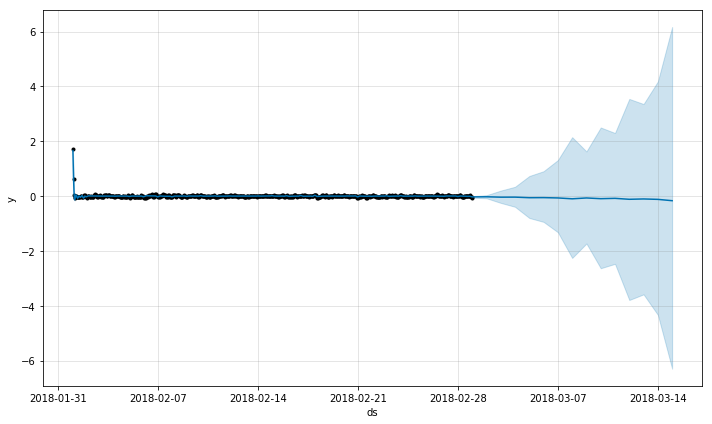

ValueError: view limit minimum -75353387.67812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

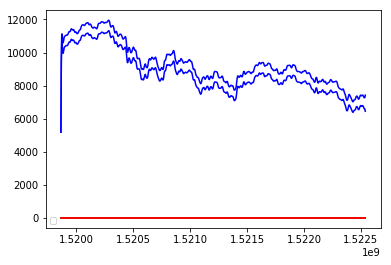

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 4)
count    720.000000
mean       0.003104
std        0.049505
min       -0.051666
25%       -0.003656
50%        0.001046
75%        0.006034
max        1.221665
Name: velocity, dtype: float64
count    7.200000e+02
mean    -4.922794e-07
std      8.846427e-06
min     -1.910198e-04
25%     -8.071061e-07
50%      1.960522e-08
75%      7.509404e-07
max      1.092861e-05
Name: acceleration, dtype: float64


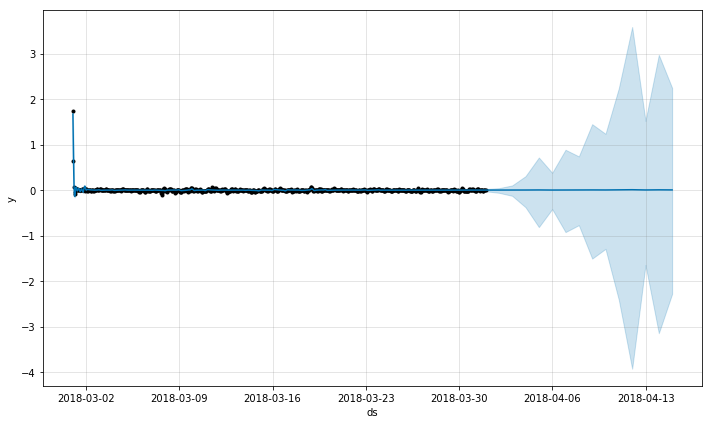

ValueError: view limit minimum -75482958.27812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

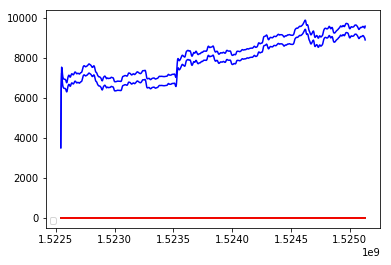

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 5)
count    744.000000
mean       0.002163
std        0.060201
min       -0.072487
25%       -0.004219
50%        0.000427
75%        0.004737
max        1.520075
Name: velocity, dtype: float64
count    7.440000e+02
mean    -5.909691e-07
std      1.060217e-05
min     -2.330821e-04
25%     -7.798215e-07
50%      2.490714e-08
75%      7.632009e-07
max      9.394099e-06
Name: acceleration, dtype: float64


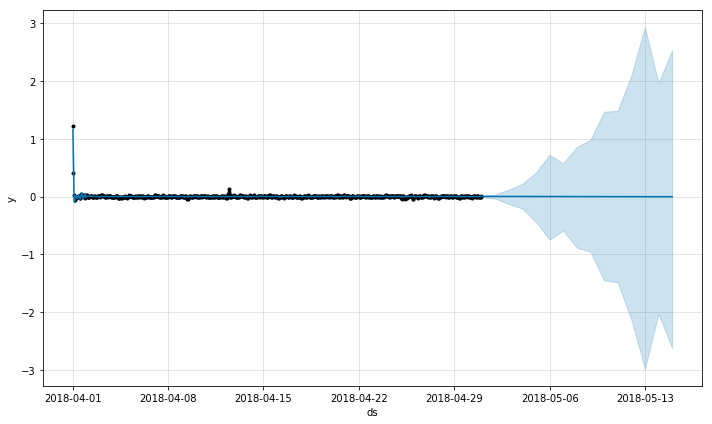

ValueError: view limit minimum -75616845.728125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

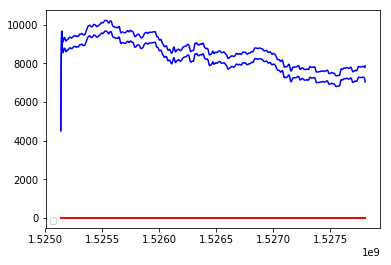

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 6)
count    720.000000
mean       0.001953
std        0.051649
min       -0.057970
25%       -0.002892
50%       -0.000284
75%        0.002366
max        1.290291
Name: velocity, dtype: float64
count    7.200000e+02
mean    -5.157353e-07
std      9.137782e-06
min     -1.983033e-04
25%     -4.563600e-07
50%      2.481502e-09
75%      4.168760e-07
max      7.649171e-06
Name: acceleration, dtype: float64


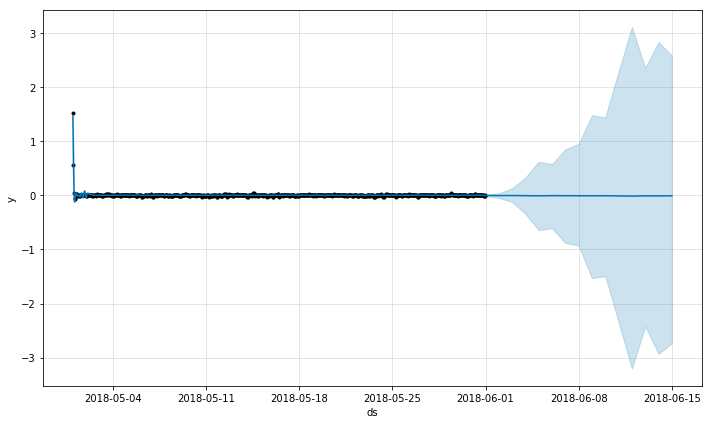

ValueError: view limit minimum -75746414.228125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

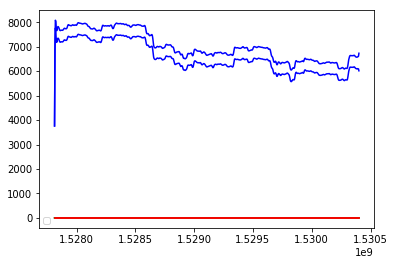

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 7)
count    744.000000
mean       0.002472
std        0.043296
min       -0.041564
25%       -0.002270
50%        0.000063
75%        0.002973
max        1.099034
Name: velocity, dtype: float64
count    7.440000e+02
mean    -4.269099e-07
std      7.672193e-06
min     -1.694573e-04
25%     -4.901119e-07
50%     -1.583393e-09
75%      4.643178e-07
max      5.956980e-06
Name: acceleration, dtype: float64


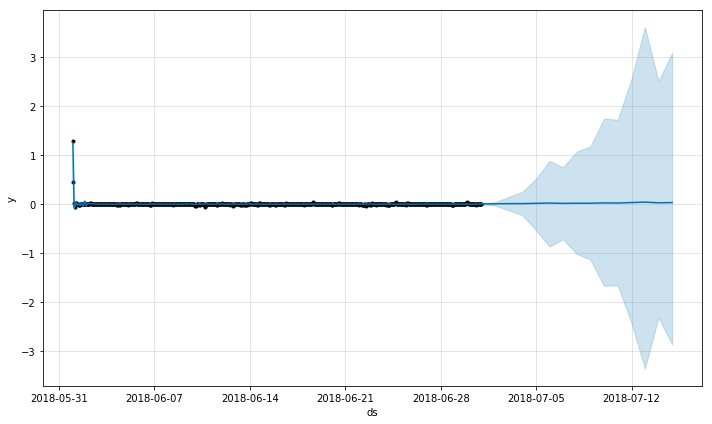

ValueError: view limit minimum -75880301.67812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

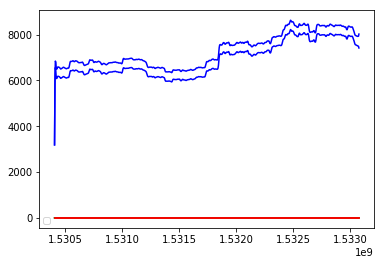

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 8)
count    744.000000
mean       0.002088
std        0.050803
min       -0.060296
25%       -0.003406
50%        0.000192
75%        0.003775
max        1.292069
Name: velocity, dtype: float64
count    7.440000e+02
mean    -5.053103e-07
std      9.069362e-06
min     -2.008528e-04
25%     -5.902090e-07
50%     -9.903850e-09
75%      5.641065e-07
max      7.799153e-06
Name: acceleration, dtype: float64


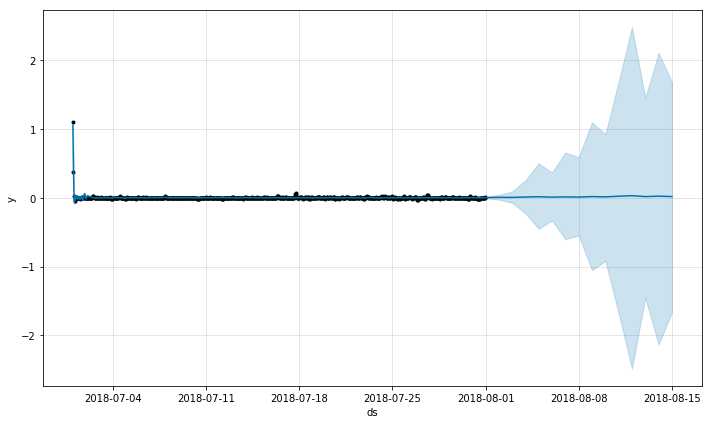

ValueError: view limit minimum -76014190.17812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

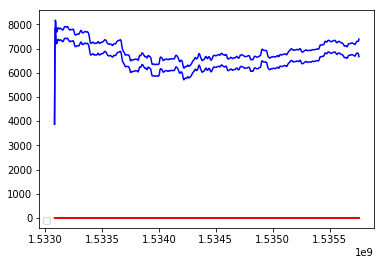

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(2018, 9)
count    483.000000
mean       0.003036
std        0.059321
min       -0.066840
25%       -0.001888
50%        0.000121
75%        0.002537
max        1.218020
Name: velocity, dtype: float64
count    4.830000e+02
mean    -7.319013e-07
std      1.055321e-05
min     -1.884634e-04
25%     -4.274937e-07
50%     -4.644824e-09
75%      3.851696e-07
max      7.166758e-06
Name: acceleration, dtype: float64


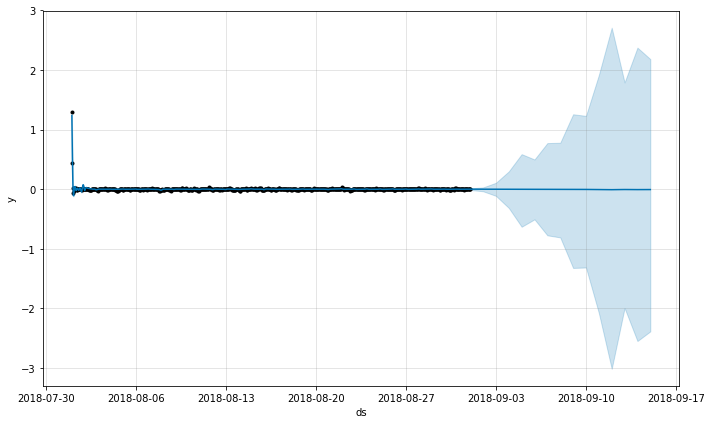

ValueError: view limit minimum -76101097.62812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

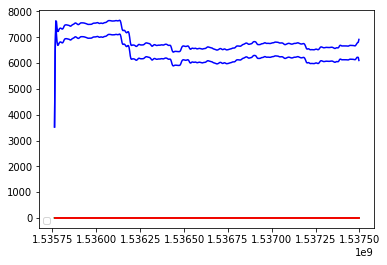

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


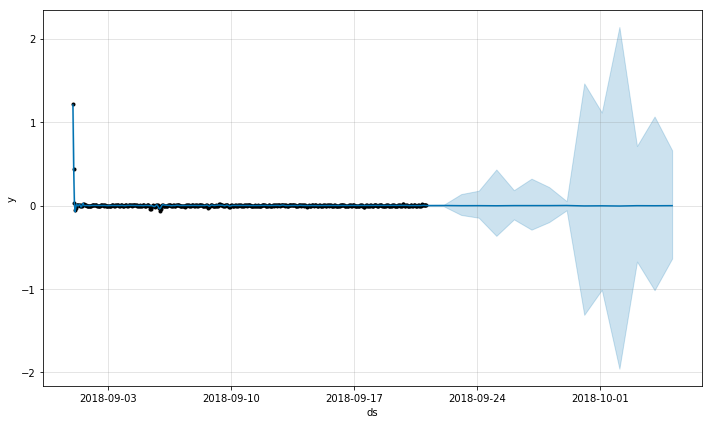

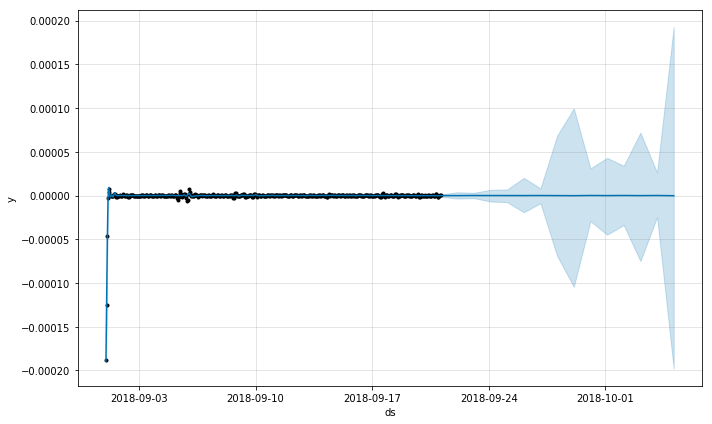

In [39]:
#monthly
d = dict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items():
    print(i)
    run(df_month)

/Users/robert/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


count    1313.000000
mean        0.000216
std         0.006493
min        -0.019450
25%        -0.000424
50%         0.000099
75%         0.000631
max         0.223563
Name: velocity, dtype: float64
count    1.313000e+03
mean    -5.014990e-08
std      1.298743e-06
min     -4.025681e-05
25%     -9.374939e-08
50%     -4.051413e-09
75%      8.918529e-08
max      2.458040e-06
Name: acceleration, dtype: float64


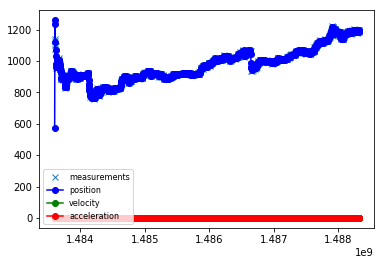

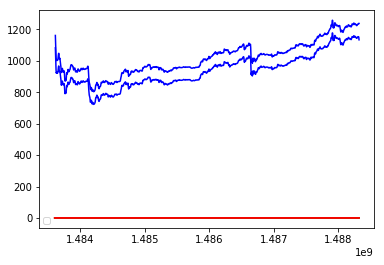

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/robert/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1464.000000
mean        0.000241
std         0.006514
min        -0.034346
25%        -0.000634
50%         0.000112
75%         0.000899
max         0.230653
Name: velocity, dtype: float64
count    1.464000e+03
mean    -4.545855e-08
std      1.227621e-06
min     -3.876923e-05
25%     -1.351181e-07
50%     -7.079386e-09
75%      1.192186e-07
max      4.133077e-06
Name: acceleration, dtype: float64


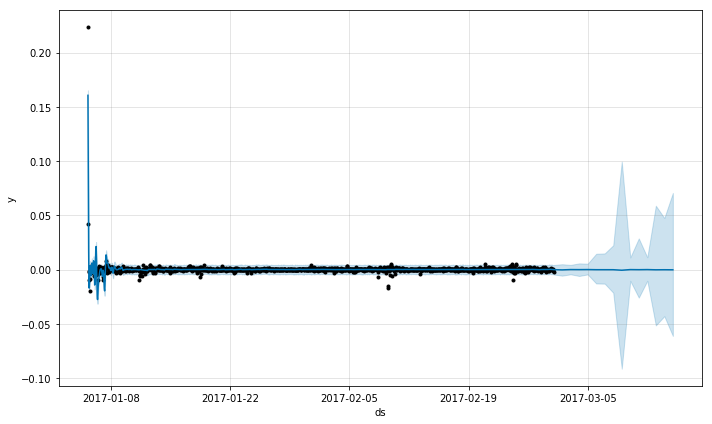

ValueError: view limit minimum -73906598.971875 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

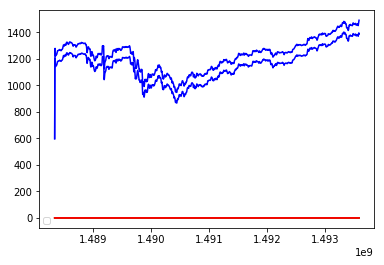

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1464.000000
mean        0.000415
std         0.009829
min        -0.067438
25%        -0.001860
50%         0.000652
75%         0.003244
max         0.276100
Name: velocity, dtype: float64
count    1.464000e+03
mean    -5.700668e-08
std      1.706933e-06
min     -4.558239e-05
25%     -4.159063e-07
50%     -2.928733e-08
75%      3.673330e-07
max      8.258617e-06
Name: acceleration, dtype: float64


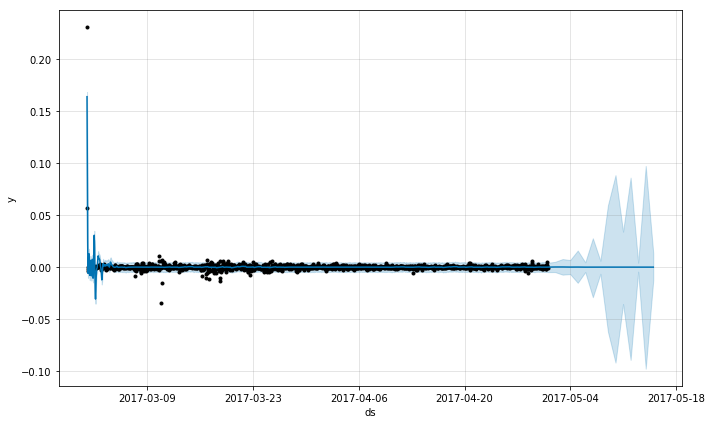

ValueError: view limit minimum -74170061.52812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

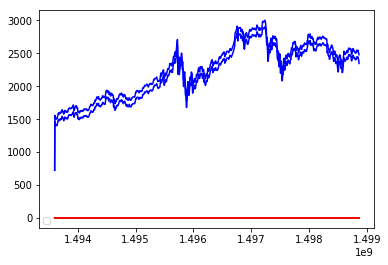

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1488.000000
mean        0.000810
std         0.013442
min        -0.030761
25%        -0.002746
50%         0.000340
75%         0.003514
max         0.443698
Name: velocity, dtype: float64
count    1.488000e+03
mean    -8.676920e-08
std      2.398910e-06
min     -7.228631e-05
25%     -4.911425e-07
50%      6.012239e-10
75%      4.442292e-07
max      5.188077e-06
Name: acceleration, dtype: float64


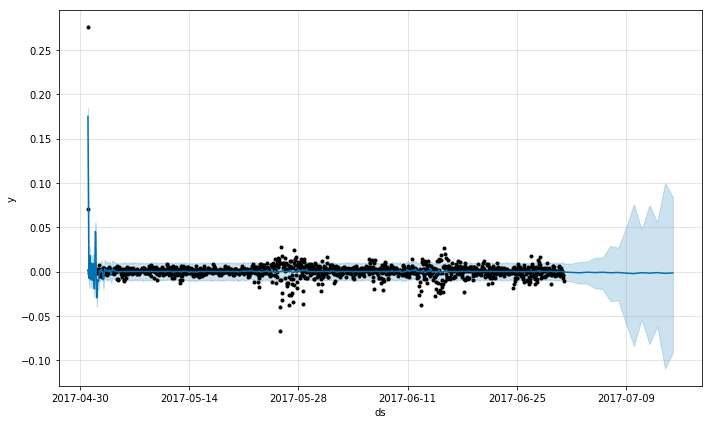

ValueError: view limit minimum -74437837.478125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

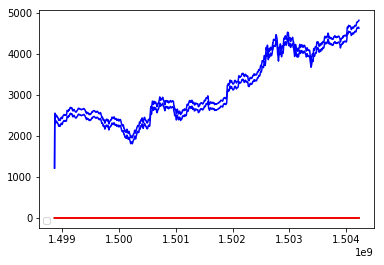

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1464.000000
mean        0.001084
std         0.025003
min        -0.052201
25%        -0.003737
50%         0.000692
75%         0.004515
max         0.858692
Name: velocity, dtype: float64
count    1.464000e+03
mean    -1.677989e-07
std      4.405026e-06
min     -1.336426e-04
25%     -6.533086e-07
50%     -5.325399e-09
75%      6.568350e-07
max      6.042202e-06
Name: acceleration, dtype: float64


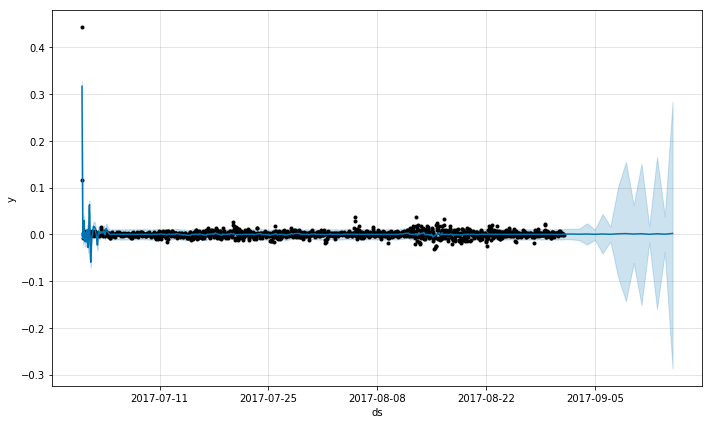

ValueError: view limit minimum -74701293.42812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

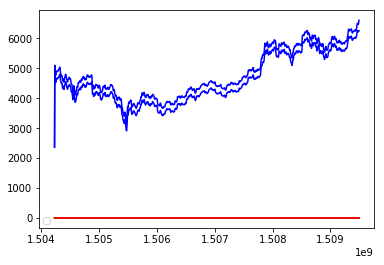

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1464.000000
mean        0.002452
std         0.049920
min        -0.199132
25%        -0.011301
50%         0.002752
75%         0.016129
max         1.175837
Name: velocity, dtype: float64
count    1.464000e+03
mean    -2.368747e-07
std      8.082397e-06
min     -1.900322e-04
25%     -2.030033e-06
50%     -5.330444e-08
75%      2.002302e-06
max      2.990963e-05
Name: acceleration, dtype: float64


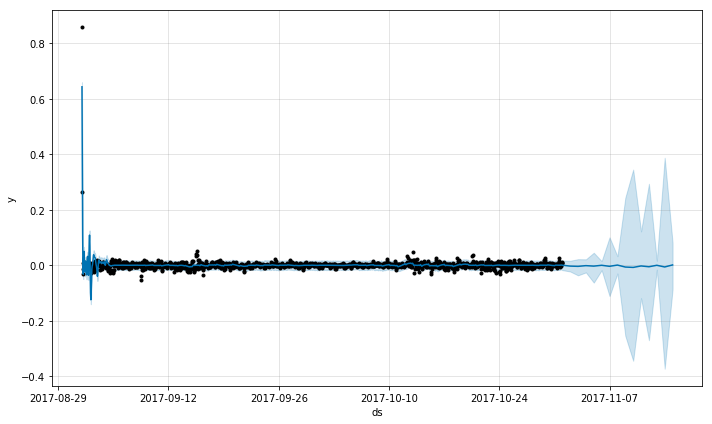

ValueError: view limit minimum -74964748.32812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

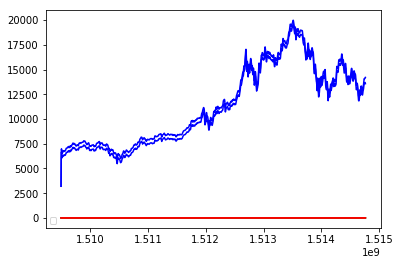

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1416.000000
mean        0.001487
std         0.070118
min        -0.182732
25%        -0.017698
50%         0.000281
75%         0.016942
max         2.244653
Name: velocity, dtype: float64
count    1.416000e+03
mean    -4.790602e-07
std      1.207617e-05
min     -3.480579e-04
25%     -2.445134e-06
50%     -7.316776e-08
75%      2.492138e-06
max      2.176571e-05
Name: acceleration, dtype: float64


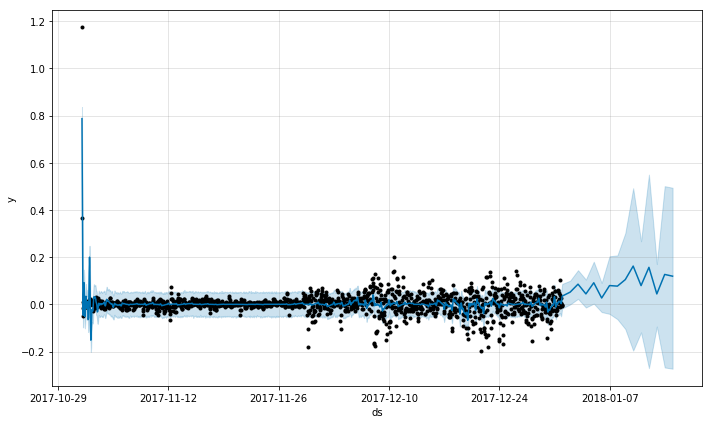

ValueError: view limit minimum -75219564.27812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

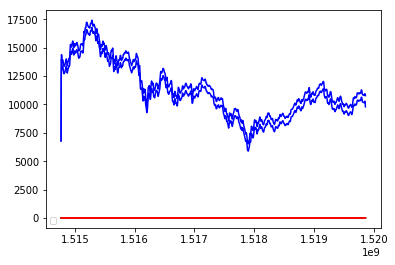

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1464.000000
mean        0.001402
std         0.051314
min        -0.103276
25%        -0.006693
50%         0.000459
75%         0.006814
max         1.766190
Name: velocity, dtype: float64
count    1.464000e+03
mean    -3.496815e-07
std      8.916281e-06
min     -2.702276e-04
25%     -1.160313e-06
50%      7.551561e-09
75%      1.111790e-06
max      1.093570e-05
Name: acceleration, dtype: float64


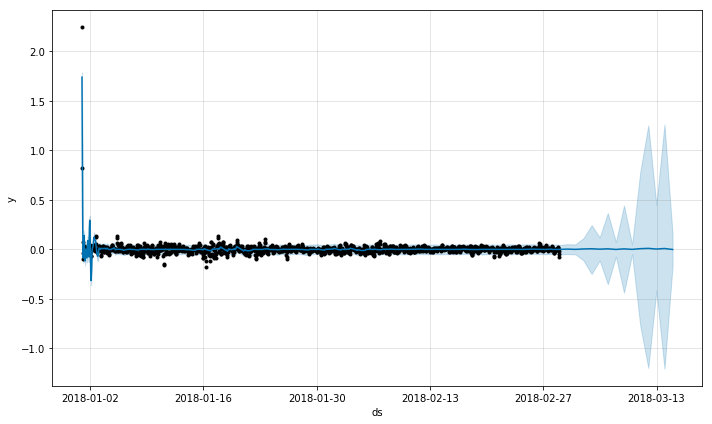

ValueError: view limit minimum -75483020.228125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

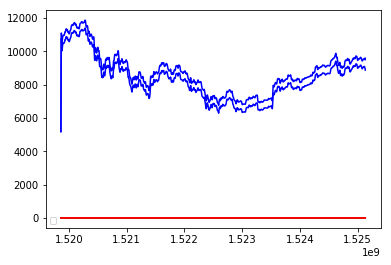

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1464.000000
mean        0.000907
std         0.043577
min        -0.062309
25%        -0.003482
50%        -0.000080
75%         0.003292
max         1.538921
Name: velocity, dtype: float64
count    1.464000e+03
mean    -3.030431e-07
std      7.638874e-06
min     -2.343895e-04
25%     -6.096330e-07
50%      9.617148e-09
75%      5.930448e-07
max      7.295947e-06
Name: acceleration, dtype: float64


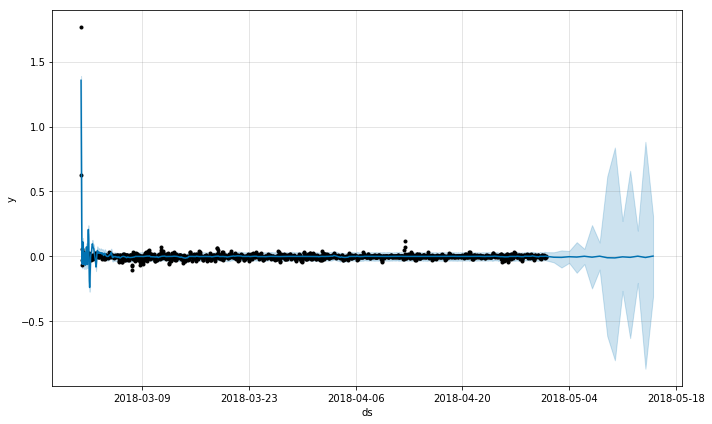

ValueError: view limit minimum -75746478.27812502 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

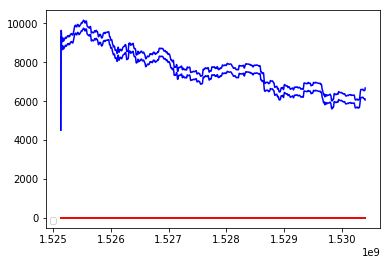

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1488.000000
mean        0.001110
std         0.031517
min        -0.040095
25%        -0.002976
50%         0.000123
75%         0.003489
max         1.116708
Name: velocity, dtype: float64
count    1.488000e+03
mean    -2.188952e-07
std      5.552199e-06
min     -1.720589e-04
25%     -5.433139e-07
50%     -4.105288e-09
75%      4.998653e-07
max      5.991505e-06
Name: acceleration, dtype: float64


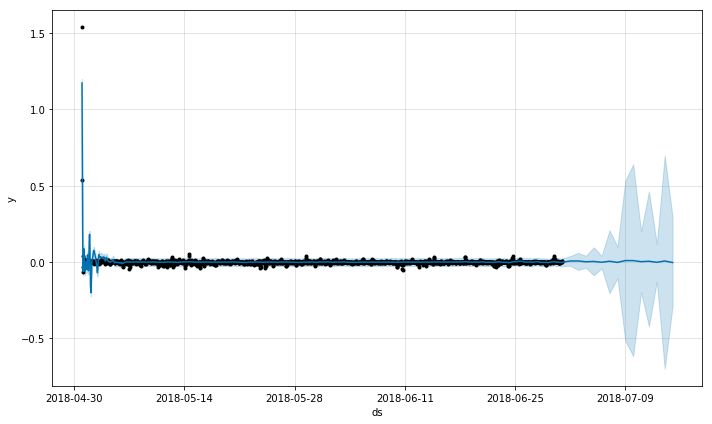

ValueError: view limit minimum -76014254.228125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

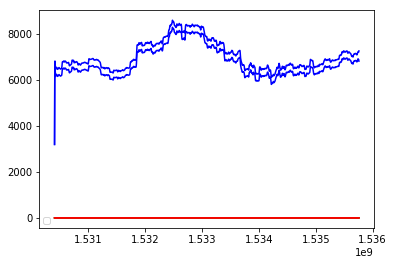

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


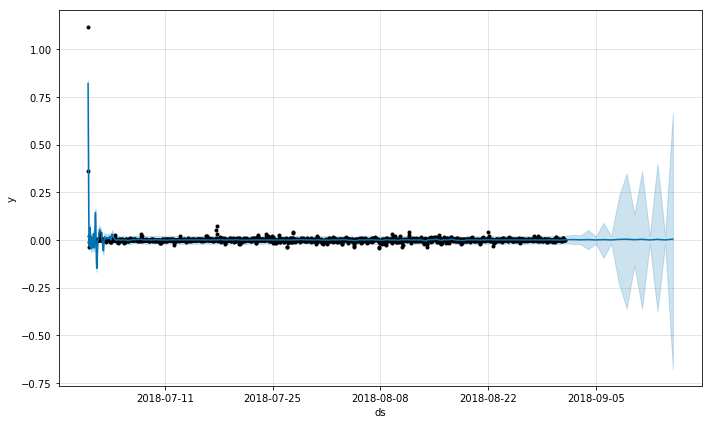

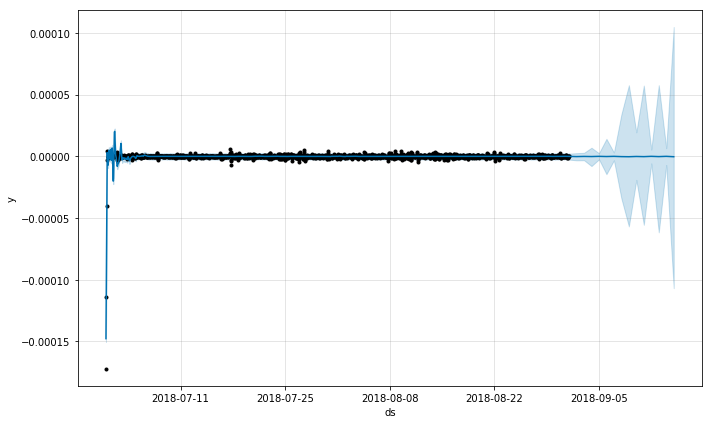

In [40]:
#bi-monthly
second = False
current_df = None
for i, df_month in d.items():
    if second:
        run(pd.concat([current_df,df_month]))
        second = False
    else:
        current_df = df_month
        second = True

/Users/robert/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


count    2057.000000
mean        0.000124
std         0.005477
min        -0.035567
25%        -0.000546
50%         0.000102
75%         0.000759
max         0.226654
Name: velocity, dtype: float64
count    2.057000e+03
mean    -3.224746e-08
std      1.093162e-06
min     -4.155099e-05
25%     -1.191882e-07
50%     -4.408147e-09
75%      1.094730e-07
max      4.412292e-06
Name: acceleration, dtype: float64


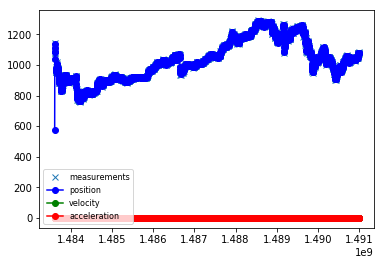

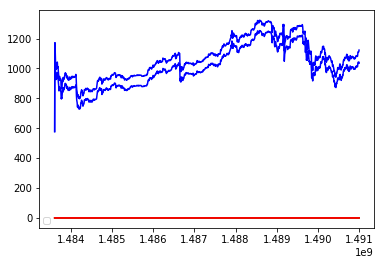

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/robert/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    2184.000000
mean        0.000287
std         0.007417
min        -0.072341
25%        -0.001097
50%         0.000304
75%         0.002071
max         0.223210
Name: velocity, dtype: float64
count    2.184000e+03
mean    -3.155750e-08
std      1.332553e-06
min     -4.014078e-05
25%     -2.942182e-07
50%     -1.396728e-08
75%      2.484358e-07
max      8.926220e-06
Name: acceleration, dtype: float64


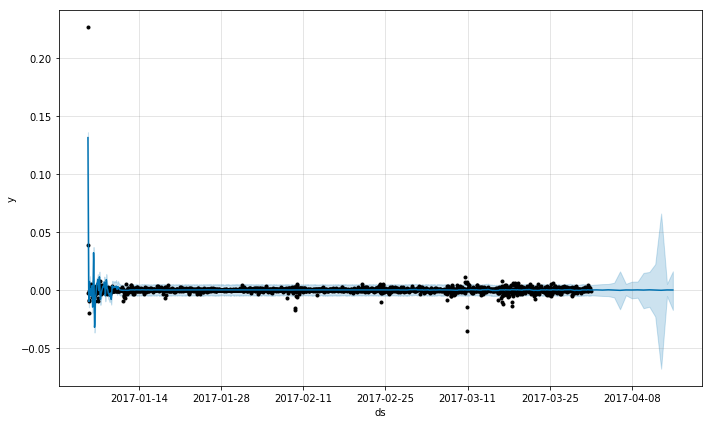

ValueError: view limit minimum -74170118.971875 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

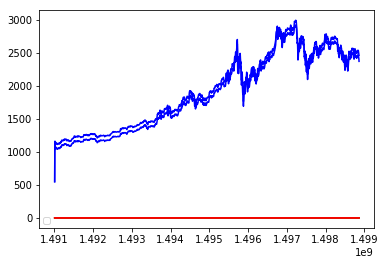

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    2208.000000
mean        0.000501
std         0.012425
min        -0.058504
25%        -0.003159
50%         0.000333
75%         0.003943
max         0.446206
Name: velocity, dtype: float64
count    2.208000e+03
mean    -5.836989e-08
std      2.132993e-06
min     -7.284589e-05
25%     -5.708361e-07
50%     -7.980407e-09
75%      5.238645e-07
max      7.185196e-06
Name: acceleration, dtype: float64


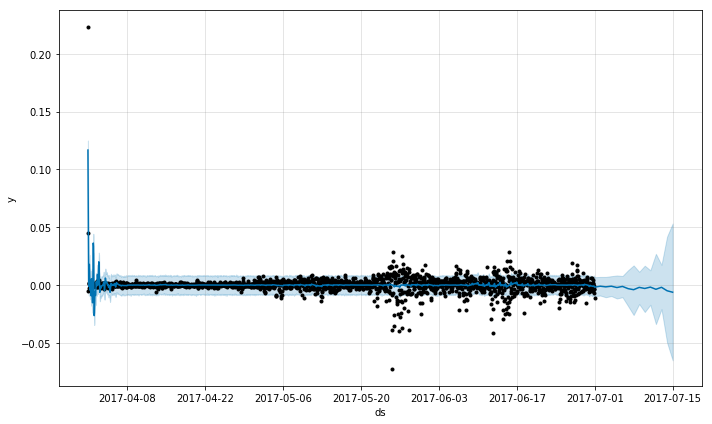

ValueError: view limit minimum -74567468.978125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

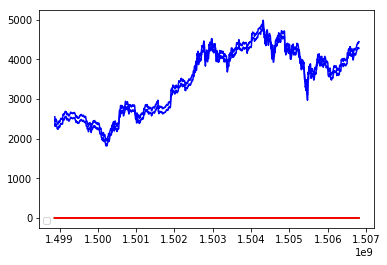

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    2208.000000
mean        0.001669
std         0.037911
min        -0.217178
25%        -0.006798
50%         0.001635
75%         0.010986
max         0.819234
Name: velocity, dtype: float64
count    2.208000e+03
mean    -1.100768e-07
std      5.680039e-06
min     -1.347375e-04
25%     -1.325361e-06
50%     -3.240737e-08
75%      1.268315e-06
max      2.978487e-05
Name: acceleration, dtype: float64


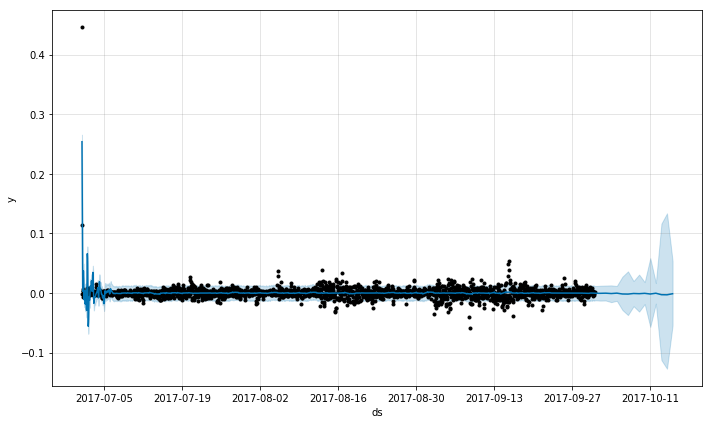

ValueError: view limit minimum -74964813.42812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

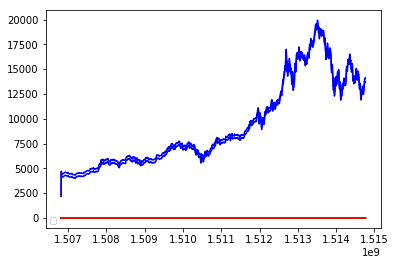

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    2160.000000
mean        0.000574
std         0.058561
min        -0.190162
25%        -0.015145
50%        -0.000156
75%         0.013331
max         2.290681
Name: velocity, dtype: float64
count    2.160000e+03
mean    -3.098933e-07
std      1.005326e-05
min     -3.563785e-04
25%     -2.065784e-06
50%     -4.571923e-08
75%      2.089291e-06
max      2.172682e-05
Name: acceleration, dtype: float64


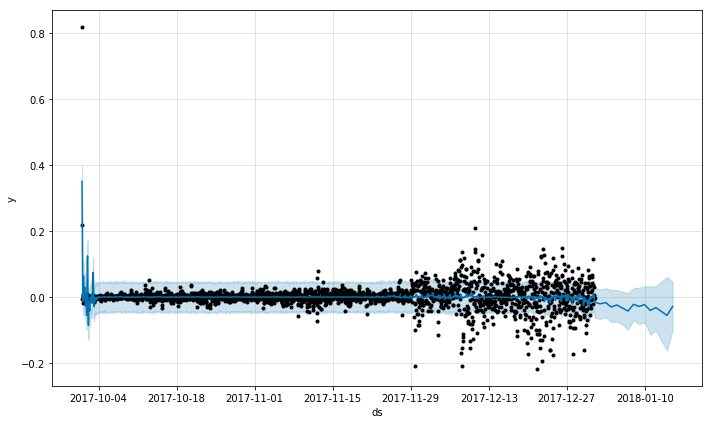

ValueError: view limit minimum -75353516.82812501 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

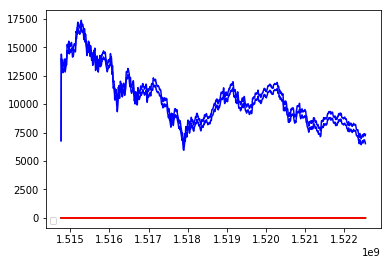

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    2184.000000
mean        0.000669
std         0.029939
min        -0.051459
25%        -0.003708
50%         0.000194
75%         0.004317
max         1.251460
Name: velocity, dtype: float64
count    2.184000e+03
mean    -1.651278e-07
std      5.279313e-06
min     -1.956329e-04
25%     -6.654495e-07
50%      6.993009e-09
75%      6.452649e-07
max      1.137991e-05
Name: acceleration, dtype: float64


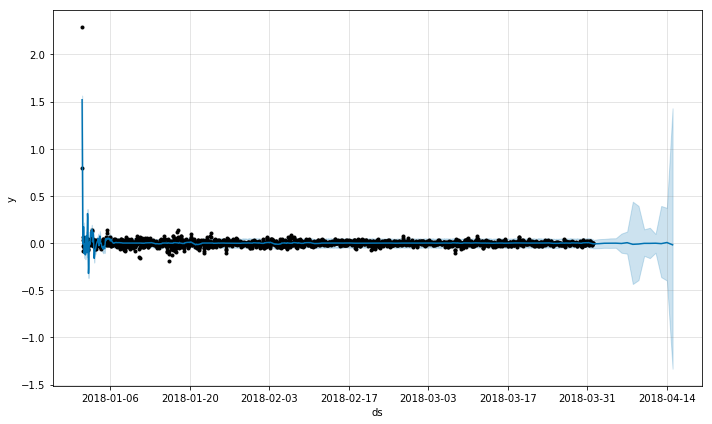

ValueError: view limit minimum -75746540.228125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

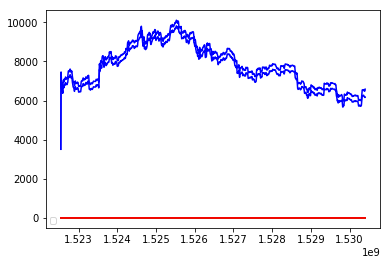

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    1971.000000
mean        0.000769
std         0.027794
min        -0.075483
25%        -0.002703
50%         0.000083
75%         0.003298
max         1.125951
Name: velocity, dtype: float64
count    1.971000e+03
mean    -1.661180e-07
std      4.889650e-06
min     -1.737178e-04
25%     -5.052594e-07
50%     -2.097019e-09
75%      4.648586e-07
max      7.481768e-06
Name: acceleration, dtype: float64


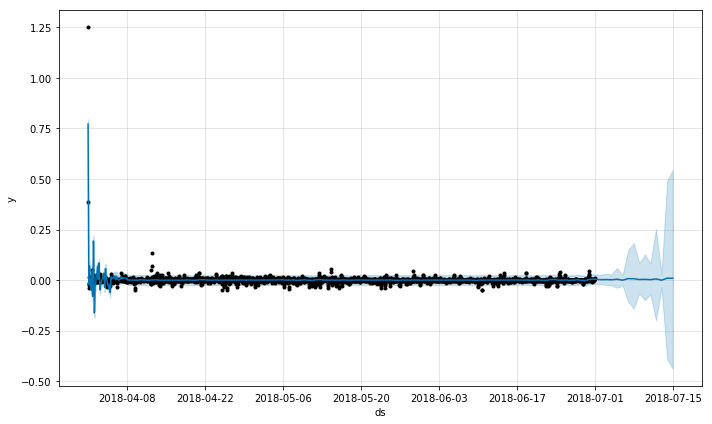

ValueError: view limit minimum -76101225.728125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

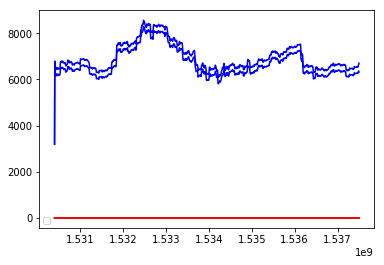

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


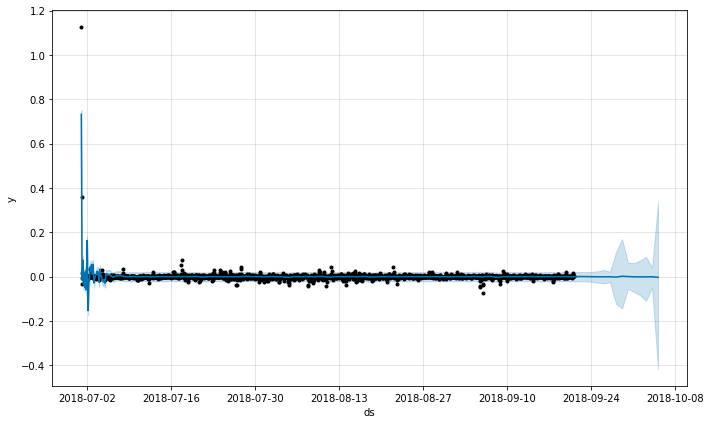

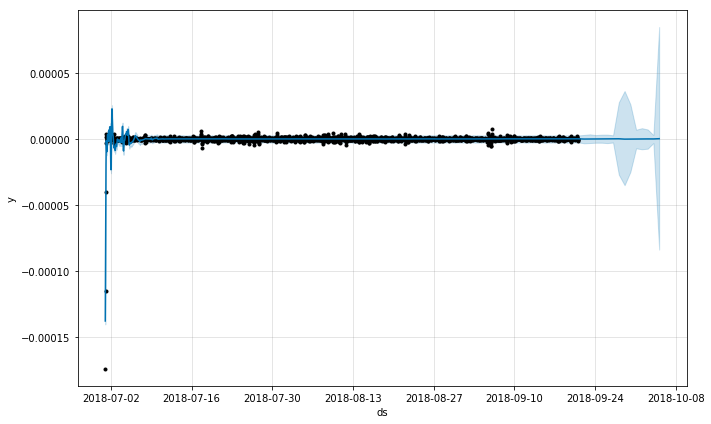

In [41]:
#quarterly
month = 1
current_df = None
for i, df_month in d.items():
    if month == 3:
        run(pd.concat([current_df,df_month]))
        month = 1
    elif month == 2:
        current_df = pd.concat([current_df,df_month])
        month += 1
    elif month == 1:
        current_df = df_month
        month += 1